# Bayesian Personalized Ranking (BPR-OPT): Experiments and Evaluation

This notebook implements Bayesian Personalized Ranking method.

This method learns relative preferences of users and does it with pairwise loss: for each user two items are chosen, one with some interaction is considered positive and second is the one, that user haven't seen, is considered negative. 3 strategies to choose these negative examples are suggested and tested: uniform negatives, popularity-based negatives (more popular items are sampled more often) and mixed.

Each combination user-positive and user-negative is scored via dot product with bias. As positive pair should have higher score than negative, difference $x_{upn} = s(u_p) - s(u_n)$ should be positive. BPR uses a logistic probability that the ordering is correct via sigmoid, so optimization objective is to minimize negative log-likelihood: $\mathcal{L}_{uij} = -\log \sigma(x_{upn})$. L2-regularization is used for embeddings matrices representing users and items and biases, so that the model doesn't overfit.

In [2]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from src.data.loader import load_all_data
from src.data.splitter import create_temporal_split, SplitConfig, add_random_timestamps, UserTemporalSplitConfig
from src.models import BPRMF, BPRConfig, UniformNegativeSampler, PopularityNegativeSampler, MixedNegativeSampler
from src.evaluation import (
    EvaluationPipeline,
    print_evaluation_results,
)

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Data Loading and Temporal Split

For this task temporal split we use differs from similarity recommendation algorithms. If we split by the year the book was published, matrix factorization inherently make no sense, as all of the validation and test books will face cold start problem. Therefore we create random variable timestamp, that simulates time the book was rated. Then, for each user we order ratings by timestamp and split train/val/test with 0.7/0.15/0.15 ratio, so that older books go in train and newer into validation and test. This creates simulation of temporal data.

In [1]:
# Load data
ratings, books, users = load_all_data('../data/raw')

ratings_ts = add_random_timestamps(ratings, start="2004-08-01", end="2004-09-30", seed=123, ts_col="timestamp")



NameError: name 'load_all_data' is not defined

In [4]:
# Initialize evaluation pipeline
K_VALUES = [10]
pipeline = EvaluationPipeline(k_values=K_VALUES, relevance_threshold=1)

# Store all results
all_results = {}

## 2. BPR-OPT

In [5]:
# Create temporal split
config = UserTemporalSplitConfig(
    train_frac=0.7,
    val_frac=0.15,
    test_frac=0.15,
    min_train=1,
    min_val=1,
    min_test=1,
    min_user_interactions = 10,
    min_item_interactions = 10,
    explicit_only = True
)


train_df, val_df, test_df, split_info = create_temporal_split(ratings_ts, books, "users", config)
test_df = pd.concat([test_df, val_df], axis=0, ignore_index=True)


--- Step 1: Filtering data ---
Original ratings: 1,149,780
After explicit filter: 433,671 ratings
After year filter (1900-2004): 377,822 ratings
Iteration 1: 71,437 ratings, 6,037 users, 3,244 items
Iteration 2: 46,508 ratings, 2,209 users, 2,237 items
Iteration 3: 42,355 ratings, 1,888 users, 2,066 items
Iteration 4: 41,433 ratings, 1,823 users, 2,027 items
Iteration 5: 41,262 ratings, 1,811 users, 2,020 items
Iteration 6: 41,253 ratings, 1,810 users, 2,020 items
Iteration 7: 41,253 ratings, 1,810 users, 2,020 items

--- Step 2: Temporal split ---
Initial split sizes (by user timestamp):
  Train: 28,144 ratings
  Val: 5,252 ratings
  Test: 7,857 ratings

--- Step 3: Ensuring test users have training history ---

--- Final Split Summary ---
Set             Ratings      Users      Items           Years   Avg Rating
----------------------------------------------------------------------
train            28,144      1,810      2,020       1930-2004         7.96
val               5,252    

In [6]:
train_items = set(train_df['isbn'].unique())
test_items = set(test_df['isbn'].unique())
overlap = train_items & test_items

print("TEMPORAL SPLIT")
print("=" * 50)
print(f"Train items: {len(train_items):,}")
print(f"Test items: {len(test_items):,}")
print(f"Overlap (items in both): {len(overlap)}")

# Shared users
train_users = set(train_df['user_id'].unique())
test_users = set(test_df['user_id'].unique())
shared_users = train_users & test_users
print(f"\nShared users (in both train and test): {len(shared_users):,}")
print(f"Test-only users: {len(test_users - train_users):,}")

TEMPORAL SPLIT
Train items: 2,020
Test items: 2,008
Overlap (items in both): 2008

Shared users (in both train and test): 1,810
Test-only users: 0


In [7]:
from typing import Dict, List, Tuple, Optional
def make_id_maps(df: pd.DataFrame, user_col="user_id", item_col="isbn") -> Tuple[Dict, Dict, np.ndarray, np.ndarray]:
    users = df[user_col].unique()
    items = df[item_col].unique()
    user2idx = {u: k for k, u in enumerate(users)}
    item2idx = {i: k for k, i in enumerate(items)}
    idx2user = users
    idx2item = items
    return user2idx, item2idx, idx2user, idx2item


def build_user_positives(
    df: pd.DataFrame,
    user2idx: Dict,
    item2idx: Dict,
    user_col="user_id",
    item_col="isbn",
    rating_col="rating",
    min_rating_pos: int = 1,
) -> List[np.ndarray]:
    """
    For each user index, store an array of positive item indices.
    Positives: rating >= min_rating_pos (default: >0, i.e., explicit positives in Book-Crossing).
    """
    n_users = len(user2idx)
    pos_lists: List[List[int]] = [[] for _ in range(n_users)]
    sub = df[df[rating_col] >= min_rating_pos][[user_col, item_col]].drop_duplicates()

    for u, i in sub.itertuples(index=False):
        if u in user2idx and i in item2idx:
            pos_lists[user2idx[u]].append(item2idx[i])

    return [np.asarray(lst, dtype=np.int32) for lst in pos_lists]


def build_seen_sets(
    df: pd.DataFrame,
    user2idx: Dict,
    item2idx: Dict,
    user_col="userId",
    item_col="itemId",
) -> List[set]:
    """Items seen in train (for filtering during recommend)."""
    n_users = len(user2idx)
    seen = [set() for _ in range(n_users)]
    sub = df[[user_col, item_col]].drop_duplicates()
    for u, i in sub.itertuples(index=False):
        if u in user2idx and i in item2idx:
            seen[user2idx[u]].add(item2idx[i])
    return seen


def train_bpr_on_bookcrossing(
    train_df: pd.DataFrame,
    user_col="user_id",
    item_col="isbn",
    rating_col="rating",
    timestamp_col="timestamp",
    min_rating_pos: int = 1,  
    neg_strategy: str = "mixed",  # "uniform" | "pop" | "mixed"
    pop_alpha: float = 1.0,
    mixed_p_uniform: float = 0.5,
    cfg: Optional[BPRConfig] = None,
) -> Tuple[BPRMF, Dict, Dict, np.ndarray, np.ndarray, List[np.ndarray], List[set]]:
    """
    Returns:
      model, user2idx, item2idx, idx2user, idx2item, user_pos, user_seen
    """
    cfg = cfg or BPRConfig()

    user2idx, item2idx, idx2user, idx2item = make_id_maps(train_df, user_col, item_col)

    n_users = len(user2idx)
    n_items = len(item2idx)

    user_pos = build_user_positives(train_df, user2idx, item2idx, user_col, item_col, rating_col, min_rating_pos)
    user_seen = build_seen_sets(train_df, user2idx, item2idx, user_col, item_col)

    tmp = train_df[[user_col, item_col]].drop_duplicates()
    pop_counts = tmp[item_col].map(item2idx).value_counts().reindex(range(n_items), fill_value=0).values

    rng = np.random.default_rng(cfg.seed)
    uniform = UniformNegativeSampler(n_items, rng)
    pop = PopularityNegativeSampler(pop_counts, rng, alpha=pop_alpha)

    if neg_strategy == "uniform":
        sampler = uniform
    elif neg_strategy == "pop":
        sampler = pop
    elif neg_strategy == "mixed":
        sampler = MixedNegativeSampler(uniform, pop, p_a=mixed_p_uniform, rng=rng)
    else:
        raise ValueError("neg_strategy must be one of: 'uniform', 'pop', 'mixed'")

    model = BPRMF(n_users, n_items, cfg)
    losses_train, ndcgs, precisions, hit_rates = model.fit(user_pos=user_pos, neg_sampler=sampler, verbose=True, val_df = test_df, 
        train_df = train_df,
        user2idx = user2idx, 
        idx2item = idx2item, 
        item2idx = item2idx)
    

    return model, user2idx, item2idx, idx2user, idx2item, user_pos, user_seen, losses_train, ndcgs, precisions, hit_rates


### Uniform negatives sampling

In [22]:
cfg = BPRConfig(
    n_factors=64,
    lr=0.05,
    reg=1e-4,
    n_epochs=25,
    batch_size=2048,
    n_samples_per_epoch=200_000,
    seed=42,
    use_item_bias=True,
)

model, user2idx, item2idx, idx2user, idx2item, user_pos, user_seen, losses_train, ndcgs, precisions, hit_rates = train_bpr_on_bookcrossing(
    train_df,
    min_rating_pos=1,          
    neg_strategy="uniform",      # try: "uniform", "pop", "mixed"
    pop_alpha=1.0,
    mixed_p_uniform=0.5,      
    cfg=cfg,
)




Epoch 01/25 | train_bpr_loss=0.53562
Epoch 02/25 | train_bpr_loss=0.33023
Epoch 03/25 | train_bpr_loss=0.17563
Epoch 04/25 | train_bpr_loss=0.10264
Epoch 05/25 | train_bpr_loss=0.06858
Epoch 06/25 | train_bpr_loss=0.04982
Epoch 07/25 | train_bpr_loss=0.03923
Epoch 08/25 | train_bpr_loss=0.03172
Epoch 09/25 | train_bpr_loss=0.02722
Epoch 10/25 | train_bpr_loss=0.02356
Epoch 11/25 | train_bpr_loss=0.02061
Epoch 12/25 | train_bpr_loss=0.01860
Epoch 13/25 | train_bpr_loss=0.01703
Epoch 14/25 | train_bpr_loss=0.01520
Epoch 15/25 | train_bpr_loss=0.01395
Epoch 16/25 | train_bpr_loss=0.01314
Epoch 17/25 | train_bpr_loss=0.01208
Epoch 18/25 | train_bpr_loss=0.01141
Epoch 19/25 | train_bpr_loss=0.01055
Epoch 20/25 | train_bpr_loss=0.01008
Epoch 21/25 | train_bpr_loss=0.00960
Epoch 22/25 | train_bpr_loss=0.00905
Epoch 23/25 | train_bpr_loss=0.00875
Epoch 24/25 | train_bpr_loss=0.00833
Epoch 25/25 | train_bpr_loss=0.00768


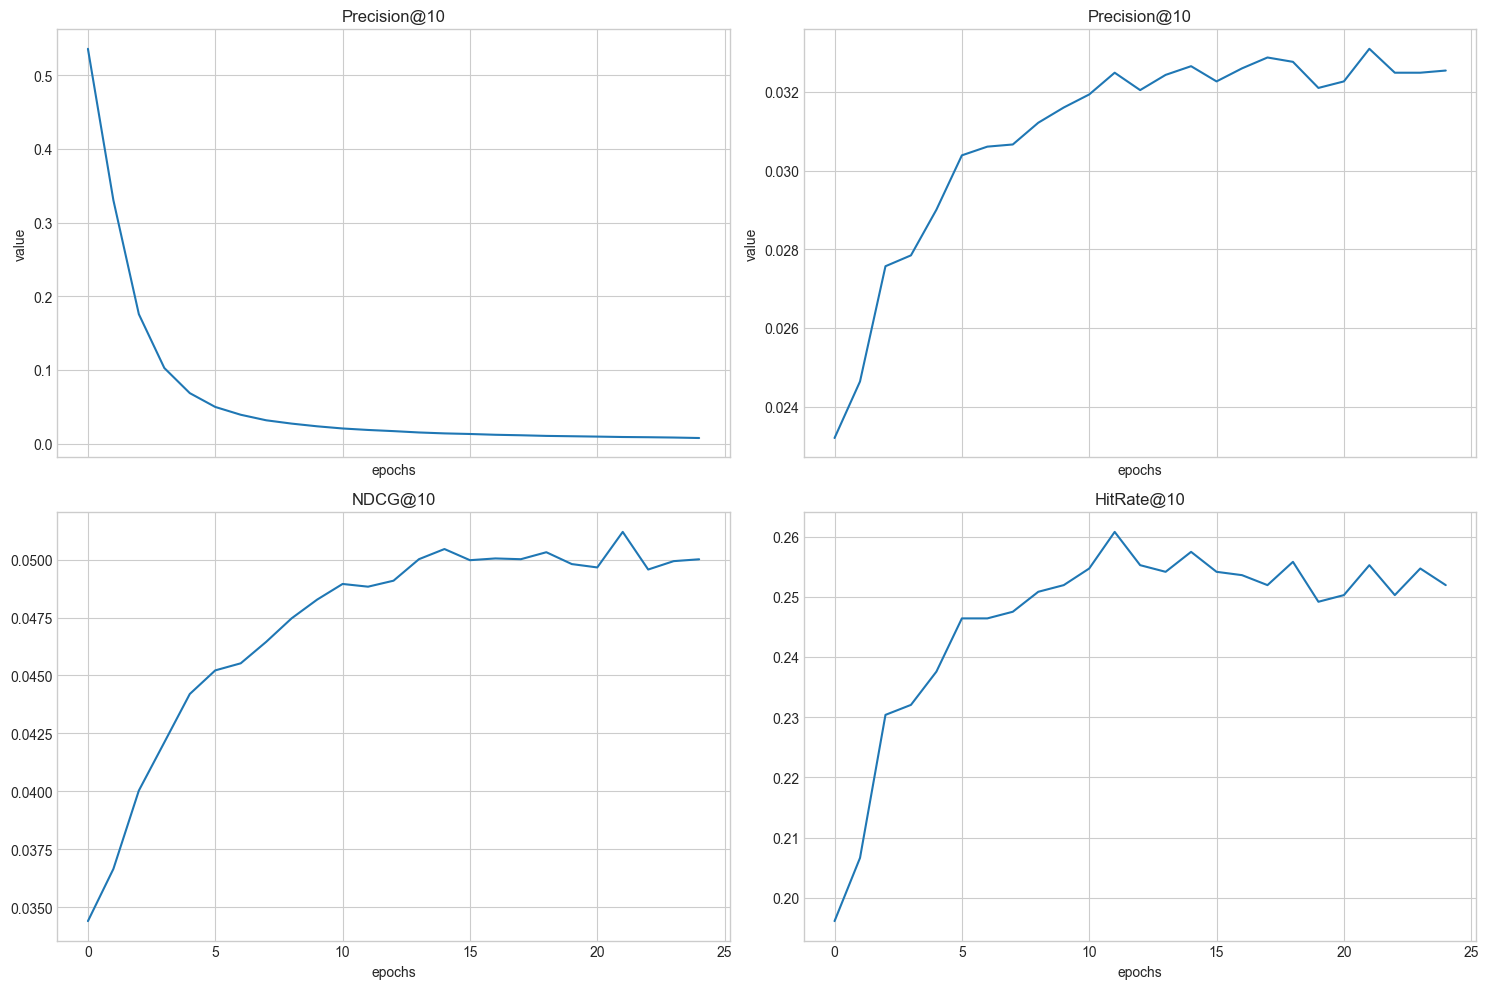

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

axes[0, 0].plot(losses_train)
axes[0, 0].set_title("Precision@10")
axes[0, 0].set_xlabel("epochs")
axes[0, 0].set_ylabel("value")

axes[0, 1].plot(precisions)
axes[0, 1].set_title("Precision@10")
axes[0, 1].set_xlabel("epochs")
axes[0, 1].set_ylabel("value")

axes[1,0].plot(ndcgs)
axes[1, 0].set_title("NDCG@10")
axes[1, 0].set_xlabel("epochs")

axes[1, 1].plot(hit_rates)
axes[1, 1].set_title("HitRate@10")
axes[1, 1].set_xlabel("epochs")

plt.tight_layout()
plt.show()

In [25]:
# Evaluate BPR - Ranking
all_results = {}
print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
model_ranking = pipeline.evaluate_ranking(model, test_df, train_df, n_recommendations=10, user2idx = user2idx, idx2item = idx2item, item2idx = item2idx)
print(f"  NDCG@10:     {model_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {model_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {model_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {model_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")
all_results['Uniform'] = model_ranking

Evaluating ranking (this may take a few minutes)...
  NDCG@10:     0.0500
  Precision@10: 0.0325
  Hit Rate@10:  0.2519
  Users eval'd: 1810
  Time: 2.1s


### Popularity-based negatives sampling

In [26]:
cfg = BPRConfig(
    n_factors=64,
    lr=0.05,
    reg=1e-4,
    n_epochs=25,
    batch_size=2048,
    n_samples_per_epoch=200_000,
    seed=42,
    use_item_bias=True,
)

model, user2idx, item2idx, idx2user, idx2item, user_pos, user_seen, losses_train, ndcgs, precisions, hit_rates = train_bpr_on_bookcrossing(
    train_df,
    min_rating_pos=1,          
    neg_strategy="pop",      # try: "uniform", "pop", "mixed"
    pop_alpha=1.0,
    mixed_p_uniform=0.5,      
    cfg=cfg,
)




Epoch 01/25 | train_bpr_loss=0.59318
Epoch 02/25 | train_bpr_loss=0.31983
Epoch 03/25 | train_bpr_loss=0.15528
Epoch 04/25 | train_bpr_loss=0.09185
Epoch 05/25 | train_bpr_loss=0.06226
Epoch 06/25 | train_bpr_loss=0.04628
Epoch 07/25 | train_bpr_loss=0.03628
Epoch 08/25 | train_bpr_loss=0.02987
Epoch 09/25 | train_bpr_loss=0.02572
Epoch 10/25 | train_bpr_loss=0.02217
Epoch 11/25 | train_bpr_loss=0.01943
Epoch 12/25 | train_bpr_loss=0.01721
Epoch 13/25 | train_bpr_loss=0.01572
Epoch 14/25 | train_bpr_loss=0.01424
Epoch 15/25 | train_bpr_loss=0.01306
Epoch 16/25 | train_bpr_loss=0.01246
Epoch 17/25 | train_bpr_loss=0.01116
Epoch 18/25 | train_bpr_loss=0.01038
Epoch 19/25 | train_bpr_loss=0.01006
Epoch 20/25 | train_bpr_loss=0.00920
Epoch 21/25 | train_bpr_loss=0.00864
Epoch 22/25 | train_bpr_loss=0.00832
Epoch 23/25 | train_bpr_loss=0.00777
Epoch 24/25 | train_bpr_loss=0.00725
Epoch 25/25 | train_bpr_loss=0.00710


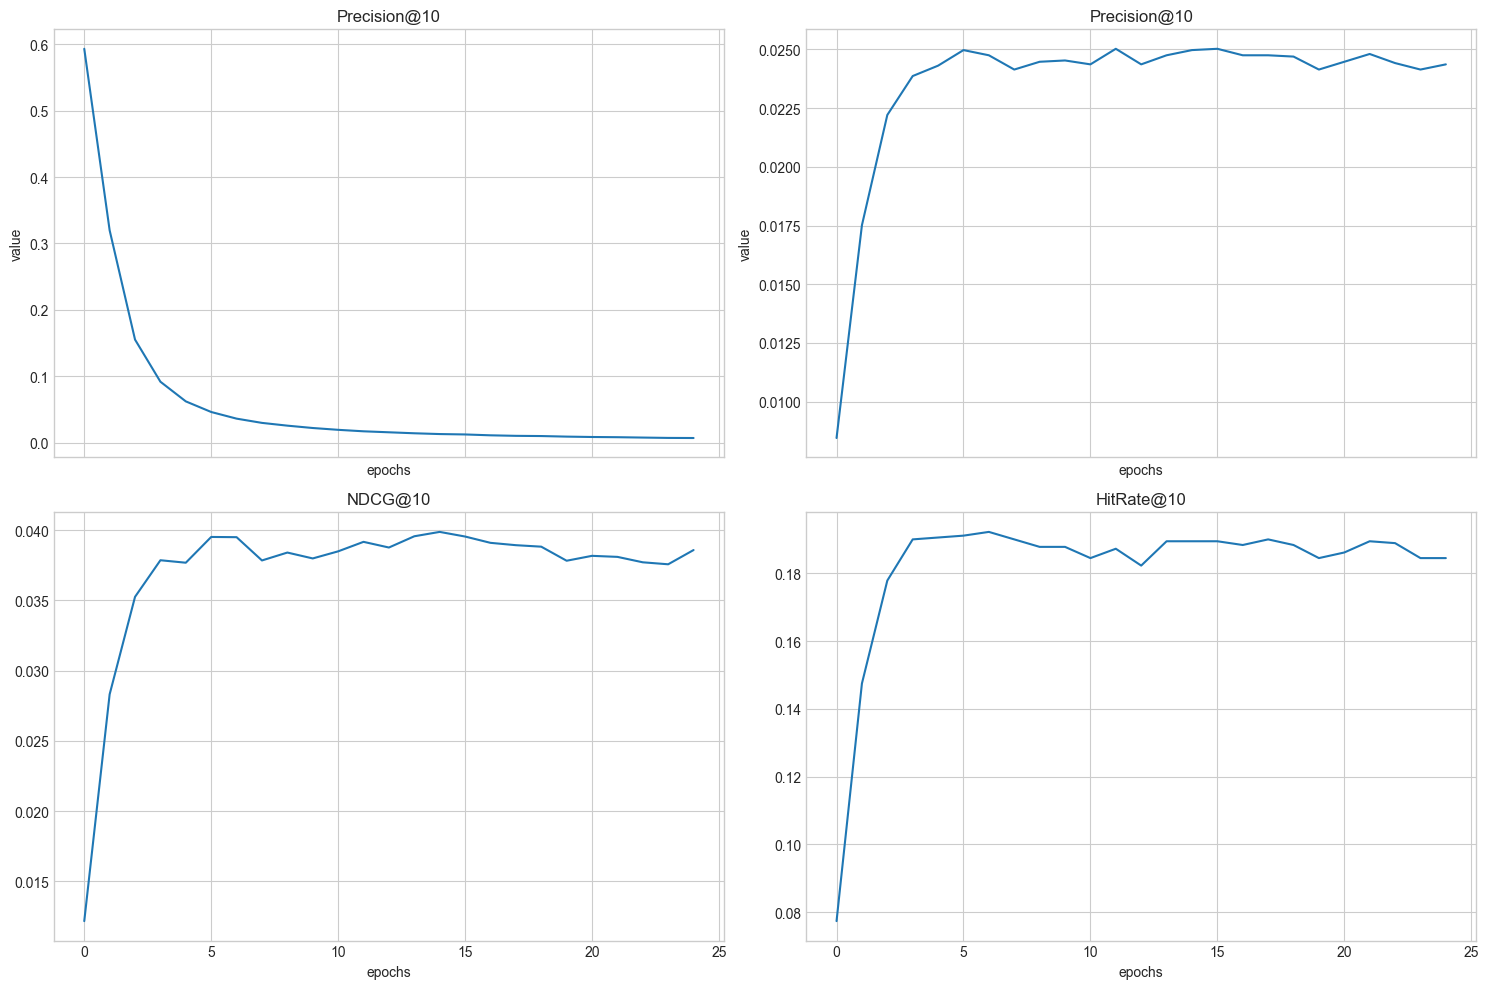

In [27]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

axes[0, 0].plot(losses_train)
axes[0, 0].set_title("Precision@10")
axes[0, 0].set_xlabel("epochs")
axes[0, 0].set_ylabel("value")

axes[0, 1].plot(precisions)
axes[0, 1].set_title("Precision@10")
axes[0, 1].set_xlabel("epochs")
axes[0, 1].set_ylabel("value")

axes[1,0].plot(ndcgs)
axes[1, 0].set_title("NDCG@10")
axes[1, 0].set_xlabel("epochs")

axes[1, 1].plot(hit_rates)
axes[1, 1].set_title("HitRate@10")
axes[1, 1].set_xlabel("epochs")

plt.tight_layout()
plt.show()

In [28]:
# Evaluate BPR - Ranking
print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
model_ranking = pipeline.evaluate_ranking(model, test_df, train_df, n_recommendations=10, user2idx = user2idx, idx2item = idx2item, item2idx = item2idx)
print(f"  NDCG@10:     {model_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {model_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {model_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {model_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")
all_results['Popularity'] = model_ranking

Evaluating ranking (this may take a few minutes)...
  NDCG@10:     0.0386
  Precision@10: 0.0244
  Hit Rate@10:  0.1845
  Users eval'd: 1810
  Time: 1.9s


### Mixed negatives sampling

In [29]:
cfg = BPRConfig(
    n_factors=64,
    lr=0.05,
    reg=1e-4,
    n_epochs=25,
    batch_size=2048,
    n_samples_per_epoch=200_000,
    seed=42,
    use_item_bias=True,
)

model, user2idx, item2idx, idx2user, idx2item, user_pos, user_seen, losses_train, ndcgs, precisions, hit_rates = train_bpr_on_bookcrossing(
    train_df,
    min_rating_pos=1,          
    neg_strategy="mixed",      # try: "uniform", "pop", "mixed"
    pop_alpha=1.0,
    mixed_p_uniform=0.5,      
    cfg=cfg,
)




Epoch 01/25 | train_bpr_loss=0.58090
Epoch 02/25 | train_bpr_loss=0.33303
Epoch 03/25 | train_bpr_loss=0.16454
Epoch 04/25 | train_bpr_loss=0.09502
Epoch 05/25 | train_bpr_loss=0.06388
Epoch 06/25 | train_bpr_loss=0.04702
Epoch 07/25 | train_bpr_loss=0.03736
Epoch 08/25 | train_bpr_loss=0.03066
Epoch 09/25 | train_bpr_loss=0.02606
Epoch 10/25 | train_bpr_loss=0.02255
Epoch 11/25 | train_bpr_loss=0.01949
Epoch 12/25 | train_bpr_loss=0.01759
Epoch 13/25 | train_bpr_loss=0.01597
Epoch 14/25 | train_bpr_loss=0.01428
Epoch 15/25 | train_bpr_loss=0.01314
Epoch 16/25 | train_bpr_loss=0.01206
Epoch 17/25 | train_bpr_loss=0.01157
Epoch 18/25 | train_bpr_loss=0.01044
Epoch 19/25 | train_bpr_loss=0.00990
Epoch 20/25 | train_bpr_loss=0.00929
Epoch 21/25 | train_bpr_loss=0.00914
Epoch 22/25 | train_bpr_loss=0.00849
Epoch 23/25 | train_bpr_loss=0.00799
Epoch 24/25 | train_bpr_loss=0.00751
Epoch 25/25 | train_bpr_loss=0.00719


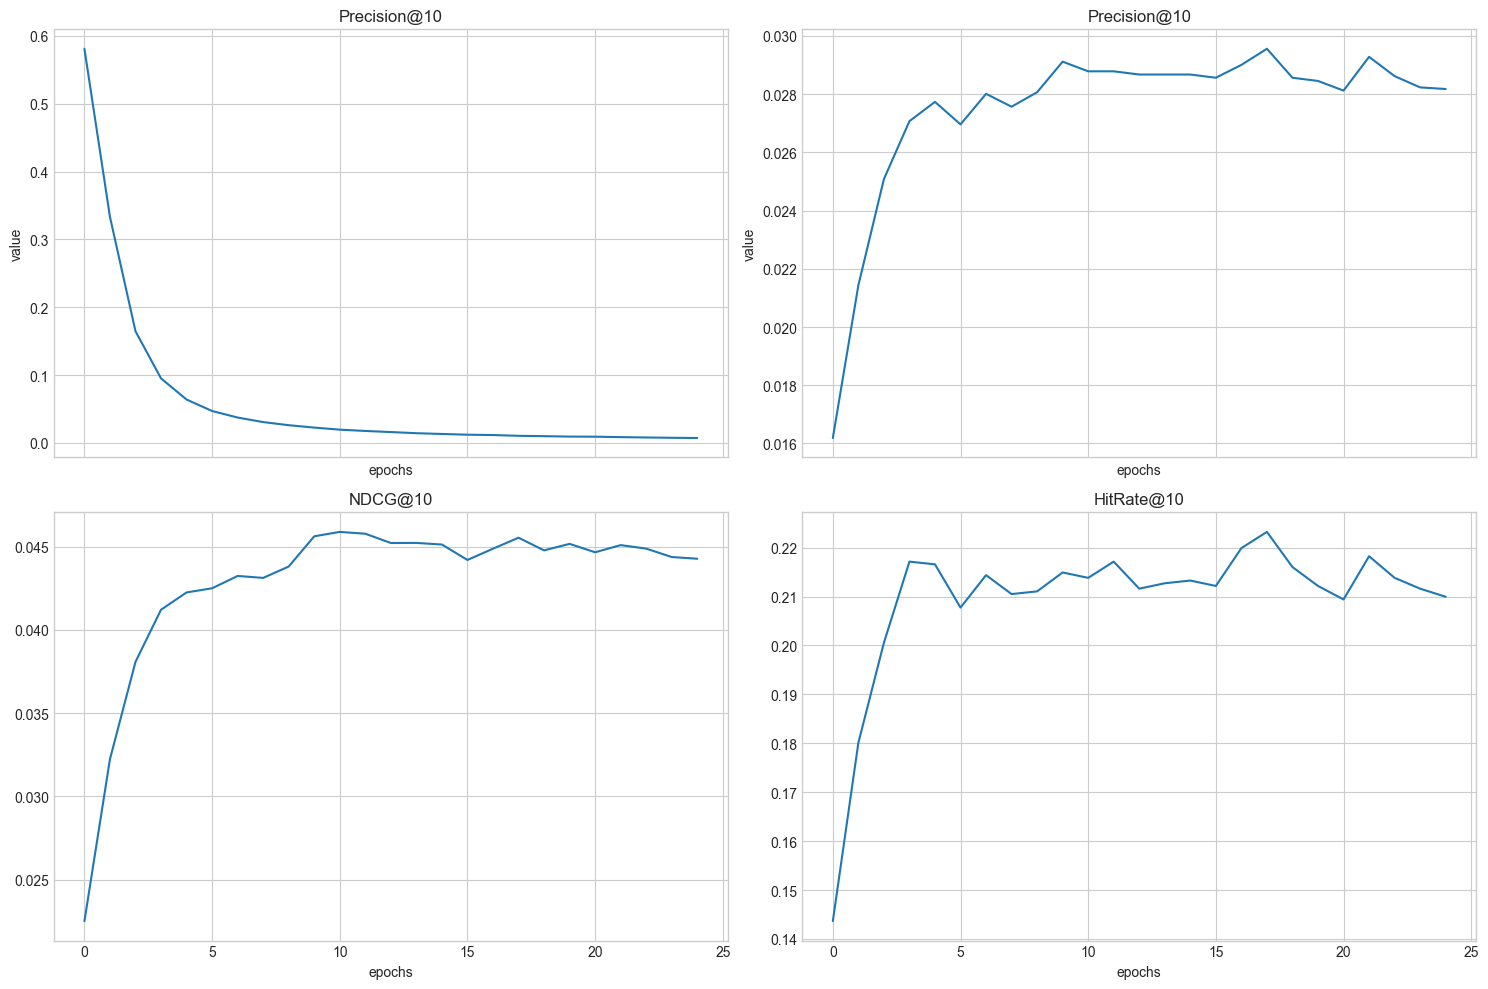

In [31]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

axes[0, 0].plot(losses_train)
axes[0, 0].set_title("Precision@10")
axes[0, 0].set_xlabel("epochs")
axes[0, 0].set_ylabel("value")

axes[0, 1].plot(precisions)
axes[0, 1].set_title("Precision@10")
axes[0, 1].set_xlabel("epochs")
axes[0, 1].set_ylabel("value")

axes[1,0].plot(ndcgs)
axes[1, 0].set_title("NDCG@10")
axes[1, 0].set_xlabel("epochs")

axes[1, 1].plot(hit_rates)
axes[1, 1].set_title("HitRate@10")
axes[1, 1].set_xlabel("epochs")

plt.tight_layout()
plt.show()

In [32]:
# Evaluate BPR - Ranking
print("Evaluating ranking (this may take a few minutes)...")
t0 = time.time()
model_ranking = pipeline.evaluate_ranking(model, test_df, train_df, n_recommendations=10, user2idx = user2idx, idx2item = idx2item, item2idx = item2idx)
print(f"  NDCG@10:     {model_ranking.get('ndcg@10', 0):.4f}")
print(f"  Precision@10: {model_ranking.get('precision@10', 0):.4f}")
print(f"  Hit Rate@10:  {model_ranking.get('hit_rate@10', 0):.4f}")
print(f"  Users eval'd: {model_ranking.get('users_evaluated', 0)}")
print(f"  Time: {time.time()-t0:.1f}s")
all_results['Mixed'] = model_ranking

Evaluating ranking (this may take a few minutes)...
  NDCG@10:     0.0443
  Precision@10: 0.0282
  Hit Rate@10:  0.2099
  Users eval'd: 1810
  Time: 2.0s


In [33]:
all_results

{'Uniform': {'precision@10': np.float64(0.0325414364640884),
  'recall@10': np.float64(0.05122252114399092),
  'ndcg@10': np.float64(0.05001415927584704),
  'hit_rate@10': np.float64(0.25193370165745854),
  'map@10': np.float64(0.021264057768381476),
  'mrr@10': np.float64(0.1038665263527142),
  'catalog_coverage@10': 0.7707920792079208,
  'users_evaluated': 1810,
  'user_coverage': 1.0},
 'Popularity': {'precision@10': np.float64(0.0243646408839779),
  'recall@10': np.float64(0.037956247395832254),
  'ndcg@10': np.float64(0.03858752452779285),
  'hit_rate@10': np.float64(0.18453038674033148),
  'map@10': np.float64(0.017371627603920938),
  'mrr@10': np.float64(0.08297202490572657),
  'catalog_coverage@10': 0.9628712871287128,
  'users_evaluated': 1810,
  'user_coverage': 1.0},
 'Mixed': {'precision@10': np.float64(0.0281767955801105),
  'recall@10': np.float64(0.04372216692359558),
  'ndcg@10': np.float64(0.04427332245769333),
  'hit_rate@10': np.float64(0.20994475138121546),
  'map@1

## 3. Results comparison

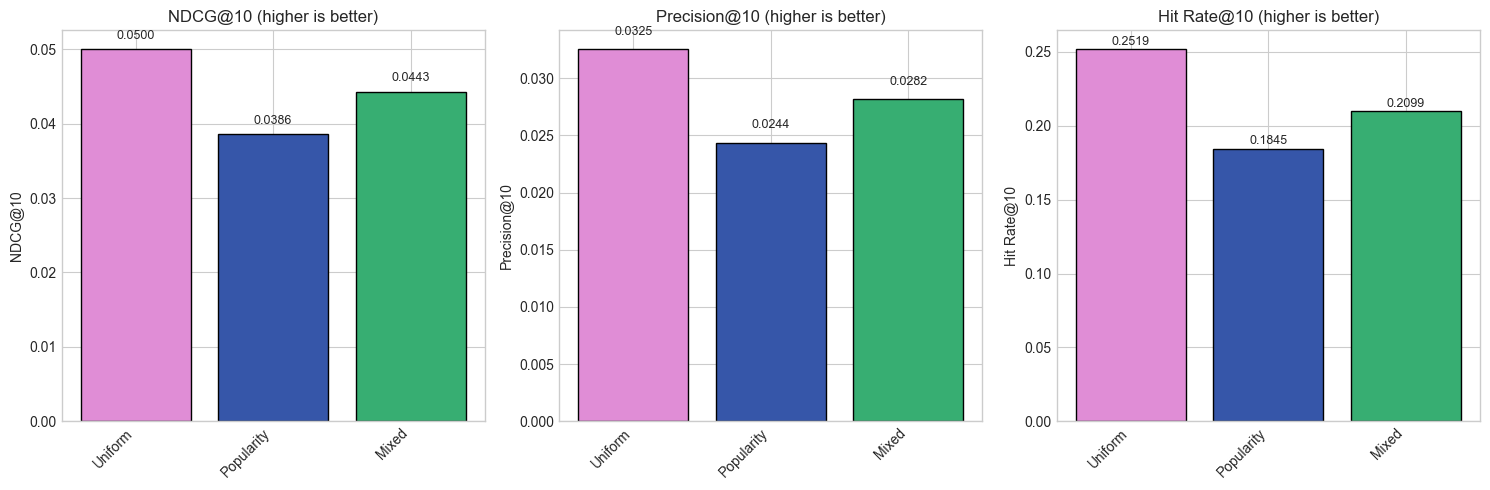

In [34]:
# Visualize ranking metrics (only models that have ranking results)
model_order = ['Uniform', 'Popularity', 'Mixed']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
ranking_colors = []
for m in model_order:
    if 'Uniform' in m:
        ranking_colors.append("#e08dd6")
    elif 'Popularity' in m:
        ranking_colors.append("#3656A9")
    elif 'Mixed' in m:
        ranking_colors.append("#37AE72")


for idx, (metric, title) in enumerate([
    ('ndcg@10', 'NDCG@10'),
    ('precision@10', 'Precision@10'),
    ('hit_rate@10', 'Hit Rate@10')
]):
    ax = axes[idx]
    vals = [all_results[m].get(metric, 0) for m in model_order]
    bars = ax.bar(range(len(model_order)), vals, color=ranking_colors, edgecolor='black')
    ax.set_xticks(range(len(model_order)))
    ax.set_xticklabels(model_order, rotation=45, ha='right')
    ax.set_ylabel(title)
    ax.set_title(f'{title} (higher is better)')
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../experiments/similarity_ranking_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## 4. Conclusions

Bayesian Personalized Ranking performs on the level of graph-based approach with all metrics slightly lower:
* NDCG@10 (0.05 vs 0.07)
* Precision@10 (0.0325 vs 0.0446)
* Hit Rate@10 (0.25 vs 0.27)

Best strategy for negative pairs sampling is Uniform, where all entries are treated with equal probability to be chosen.
